Today we will try to recognise digits in images using neural networks.

In [2]:
# import libraries
import torch
import torchvision
import numpy as np
import random as rd

In [3]:
# Update hyperparameters for the model
# Hyperparameters are values that you use to adjust the model parameters.

# Number of epochs is the number of times you go over training data
numEpochs = 3

# batch size is the size of the chunk used each time for training (or testing)
batch_size_train = 64
batch_size_test = 64
# The rate at which the neural network learns
learning_rate = 0.01
# momentum is the speedup in learning rate depending on the current learning velocity
momentum = 0.5
# After how many steps should we print outputs
log_intervals = 10

In [4]:
random_seed = 1996
torch.manual_seed(random_seed)
np.random.seed(random_seed)
rd.seed(random_seed)

In [5]:
# Load the datasets
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))



In [6]:
# Load the datasets in a format that pytorch can use
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

In [7]:
examplesEnumerator = enumerate(test_dataloader)


In [8]:
batch_id_for_example, (exampleData,exampleLabel) = next(examplesEnumerator)

print("batch_id_for_example=",batch_id_for_example)
print("exampleLabel=",exampleLabel)
print("exampleData.shape=",exampleData.shape)

batch_id_for_example= 0
exampleLabel= tensor([8, 5, 7, 5, 2, 7, 7, 9, 9, 2, 0, 1, 6, 0, 9, 7, 2, 6, 0, 3, 4, 8, 0, 6,
        9, 7, 2, 5, 8, 6, 5, 3, 6, 4, 6, 9, 5, 3, 6, 7, 0, 2, 9, 9, 8, 2, 8, 0,
        4, 6, 7, 7, 7, 6, 9, 8, 4, 2, 4, 3, 9, 1, 6, 2])
exampleData.shape= torch.Size([64, 1, 28, 28])


C:\Users\tusht\AppData\Local\Temp\ipykernel_12208\1788316080.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


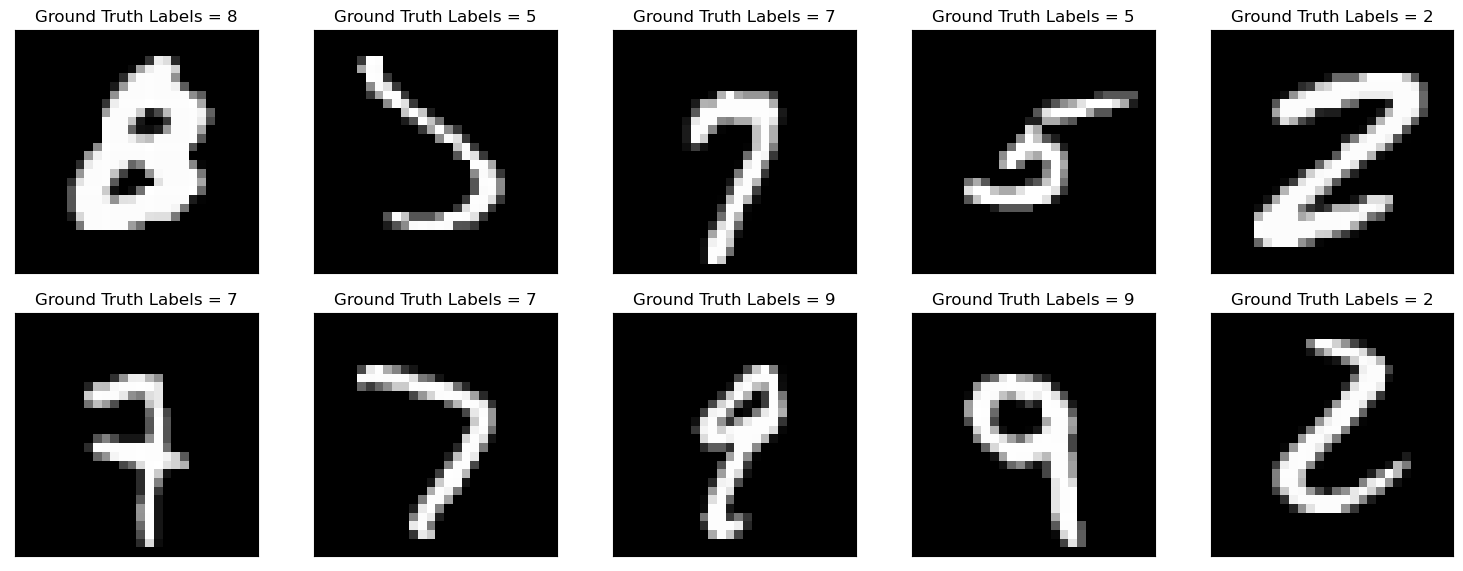

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6))

for figureNumber in range(10):
    plt.subplot(2,5,figureNumber+1)
    plt.tight_layout()
    plt.imshow(exampleData[figureNumber][0], cmap="gray",interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.title("Ground Truth Labels = %d"%exampleLabel[figureNumber])


fig.show()



In [10]:
# import the libraries used for building the network
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        # RELU = rectified linear unit
        # maxpool = pools the information and gives the max
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # softmax = outputs the maximum value, but does it within thresholds
        return F.log_softmax(x)

In [12]:
# student = model
network = Net()
# teacher = optimizer
# SGD = stochastic gradient descent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [13]:
# store the training values and errors
train_losses = []
train_counter = []
test_losses = []
print("len(train_dataloader.dataset)=",len(train_dataloader.dataset))
test_counter = [i*len(train_dataloader.dataset) for i in range(numEpochs+1)]
print("test_counter=",test_counter)

len(train_dataloader.dataset)= 60000
test_counter= [0, 60000, 120000, 180000]


In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_intervals == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                       100. * batch_idx / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [15]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

In [16]:
test()
for epoch in range(1, numEpochs + 1):
    train(epoch)
    test()

C:\Users\tusht\AppData\Local\Temp\ipykernel_12208\44468947.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\tusht\anaconda3\envs\nyenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3081, Accuracy: 950/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309765
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290458
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.291238
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.292878
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.252179
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.237053
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.229858
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.175314
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.171839
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.063246
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.057192
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.955937
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.961645
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.670354
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.749771
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.497263
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.321234
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.233530
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.238351
Train Epoch: 1 [12160/

#loss plots
We will plot the losses

C:\Users\tusht\AppData\Local\Temp\ipykernel_12208\997450198.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


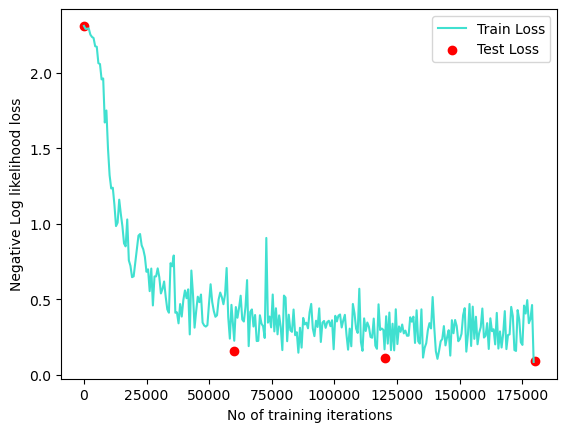

In [18]:
figure = plt.figure()
plt.plot(train_counter,train_losses,color = "Turquoise")
plt.scatter(test_counter,test_losses,color = "Red")
plt.xlabel('No of training iterations')
plt.ylabel('Negative Log likelihood loss')
plt.legend(["Train Loss","Test Loss"],loc="upper right")
figure.show()